# Описание задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


# Описание услуг
Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных
Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Описание данные в таблицах
- BeginDate – дата начала пользования услугами.
- EndDate – дата окончания пользования услугами.
- Type – тип оплаты: ежемесячный, годовой и тд.
- PaperlessBilling – безналичный расчет.
- PaymentMethod – способ оплаты.
- MonthlyCharges – ежемесячные траты на услуги.
- TotalCharges – всего потрачено денег на услуги.
- Dependents – наличие иждивенцев.
- Senior Citizen – наличие пенсионного статуса по возрасту.
- Partner – наличие супруга(и).
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.


# План работы
1. Выгрузить данные, проверить пропуски в таблицах, узнать тип данных в таблицах оставить коментарии и сделать выводы.
2. Провести предобработку и исследовательский анализ. Определить целевой признак и сделать выводы.
3. Разделить исходные данные на тренировачную и тестевую выборки. 
4. Определить лучшие модели на тренировачной выборке с помощью подбора параметров.
5. Протестировать модели на тестевой выборке.
6. Сделать анализ лучшей модели (важность признаков, матрица ошибок)
7. Сделать общий вывод.

In [6]:
# Выгрузим все необходимые библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, make_scorer, f1_score
from sklearn.utils import shuffle

from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool

# Выставим фон с сеткой в seaborn
sns.set_style("whitegrid")

In [7]:
# Выгрузим данные и изучим признаки
try:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    contract_df = pd.read_csv('D://Data Science//Проекты//datasets//final_provider//contract.csv')
    personal_df = pd.read_csv('D://Data Science//Проекты//datasets//final_provider//personal.csv')
    internet_df = pd.read_csv('D://Data Science//Проекты//datasets//final_provider//internet.csv')
    phone_df = pd.read_csv('D://Data Science//Проекты//datasets//final_provider//phone.csv')

# Выведем пять первых и последних столбцов датафрейма
display(contract_df,
        personal_df,
        internet_df,
        phone_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [8]:
# Создадим функцию, которая выведет общую информацию, количество пропущенных значений, дубликатов и уникальныъ значений таблиц
def information(data):
    for i in data.columns:
        print(f'\nУникальные значения {i}:\n', data[i].unique())
    print('\nКоличество пропущенных значений:\n', data.isna().sum())
    print('\nКоличество дубликатов в датафрейме:', data.duplicated().sum(), '\n')
    data.info()

In [9]:
# Выведем информацию о датафрейме contract_df 
information(contract_df)


Уникальные значения customerID:
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Уникальные значения BeginDate:
 ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '20

In [10]:
# Выведем информацию о датафрейме personal_df 
information(personal_df)


Уникальные значения customerID:
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Уникальные значения gender:
 ['Female' 'Male']

Уникальные значения SeniorCitizen:
 [0 1]

Уникальные значения Partner:
 ['Yes' 'No']

Уникальные значения Dependents:
 ['No' 'Yes']

Количество пропущенных значений:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество дубликатов в датафрейме: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
# Выведем информацию о датафрейме internet_df 
information(internet_df)


Уникальные значения customerID:
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Уникальные значения InternetService:
 ['DSL' 'Fiber optic']

Уникальные значения OnlineSecurity:
 ['No' 'Yes']

Уникальные значения OnlineBackup:
 ['Yes' 'No']

Уникальные значения DeviceProtection:
 ['No' 'Yes']

Уникальные значения TechSupport:
 ['No' 'Yes']

Уникальные значения StreamingTV:
 ['No' 'Yes']

Уникальные значения StreamingMovies:
 ['No' 'Yes']

Количество пропущенных значений:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество дубликатов в датафрейме: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   Inter

In [12]:
# Выведем информацию о датафрейме phone_df 
information(phone_df)


Уникальные значения customerID:
 ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

Уникальные значения MultipleLines:
 ['No' 'Yes']

Количество пропущенных значений:
 customerID       0
MultipleLines    0
dtype: int64

Количество дубликатов в датафрейме: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод:** Во всех таблицах отсутсвуют пропущенные значения и дубликаты.
 * В фрейме contract_df, таблицу BeginDate необходимо привести к формату datetime, таблица EndDate, показывает дату действия договора с клиентом. Эта таблица будет целевым признаком, где значение No показывает, что клиент пользуется услугами данного мобильного аператора, значение нужно поменять на сегодняшнюю дату, применив заглушку к No и привести к формату datetime. Таблицу TotalCharges приведем к числовому типу. 
 
 * В фрейме personal_df, internet_df и phone_df доплнительных правок не требуется. Все таблицы в этих фреймах имеют бинарные признаки.
 
 Все фреймы можно объединить в один по таблице customerID

# Вопросы
1. Нужно ли применять One Hot Encoding ко всем категориальным признакам?

2. Какую метрику надо использовать и какие значение метрики необходимы при определении лучшей модели?

# Предобработка данных 

In [13]:
# Заменим значения EndDate на дату выгрузки фрейма (2020-02-01)
contract_df['EndDate'] = contract_df['EndDate'].replace(['No'], ['2020-02-01'])
# Проверим, как провелась замена No на 10.05.2023
print(contract_df[contract_df['EndDate'] == 'No'].shape[0])

0


In [14]:
# Переведем таблицы EndDate и BeginDate к формату datetime
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d')
# Проверим тип данных 
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [15]:
# Отсартируем и выведем значения данной таблицы
contract_df['TotalCharges'].sort_values().unique()

array([' ', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)

In [16]:
# Заменяем пропущенные значения на 0
contract_df['TotalCharges'] = contract_df['TotalCharges'].replace([' '], 0)

Таблица TotalCharges (Количество потраченных денег) имеет дробные значения (копейки). Не будем их учитывать и переведем сначала в тип float, а затем в формат int.

In [17]:
# Переведем столбец TotalCharges в формат float 
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype(float)
# Переведем столбец TotalCharges в формат int
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype(int)

In [18]:
# Объединим все фреймы по индификатору клиента customerID
client_df = contract_df \
    .merge(personal_df, how='left', on='customerID') \
    .merge(internet_df, how='left', on='customerID') \
    .merge(phone_df, how='left', on='customerID')

# Установим customerID в качестве индекса, чтобы, так как они являются уникальным индификатором поля
client_df = client_df.set_index('customerID')

In [19]:
# Выведем информацию об объединенном фрейме
information(client_df)


Уникальные значения BeginDate:
 ['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2019-06-01T00:00:00.000000000' '2016-04-01T00:00:00.000

В некоторых таблицах после объединения появились пропущенные значения, скорее всего это связано с тем, что некоторые клиенты не пользовались, какими-то  услугами оператора, поэтому логичнее всего заменить пропущенные значения на No

In [20]:
# Произведем замену пустых значений через цикл for
for column in ('InternetService', 
               'OnlineSecurity', 
               'OnlineBackup', 
               'DeviceProtection', 
               'TechSupport', 
               'StreamingTV', 
               'StreamingMovies', 
               'MultipleLines'):
    client_df[column] = client_df[column].fillna('No')
    
# Проверим фрейм на пропуски
client_df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Предобработка произведена, перейдем к анализу данных 

# Исследование данных

Создадим столбец network_use_days (количество дней использования сети), который покажет сколько пользователей пользовались сетью

In [21]:
# Создаем таблицу Network_use_days
client_df['Network_use_days'] =  (client_df['EndDate'] - client_df['BeginDate']).dt.days
client_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Network_use_days
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,337


In [22]:
# Для анализа саздадим категориальные и бинарные признаки  
num_columns = ['MonthlyCharges', 
               'TotalCharges',
               'Network_use_days']

cat_columns = ['Type',
               'PaperlessBilling',
               'PaymentMethod',
               'gender',
               'Partner',
               'Dependents',
               'InternetService', 
               'OnlineSecurity', 
               'OnlineBackup', 
               'DeviceProtection',
               'TechSupport', 
               'StreamingTV',
               'SeniorCitizen',
               'StreamingMovies',
               'MultipleLines']

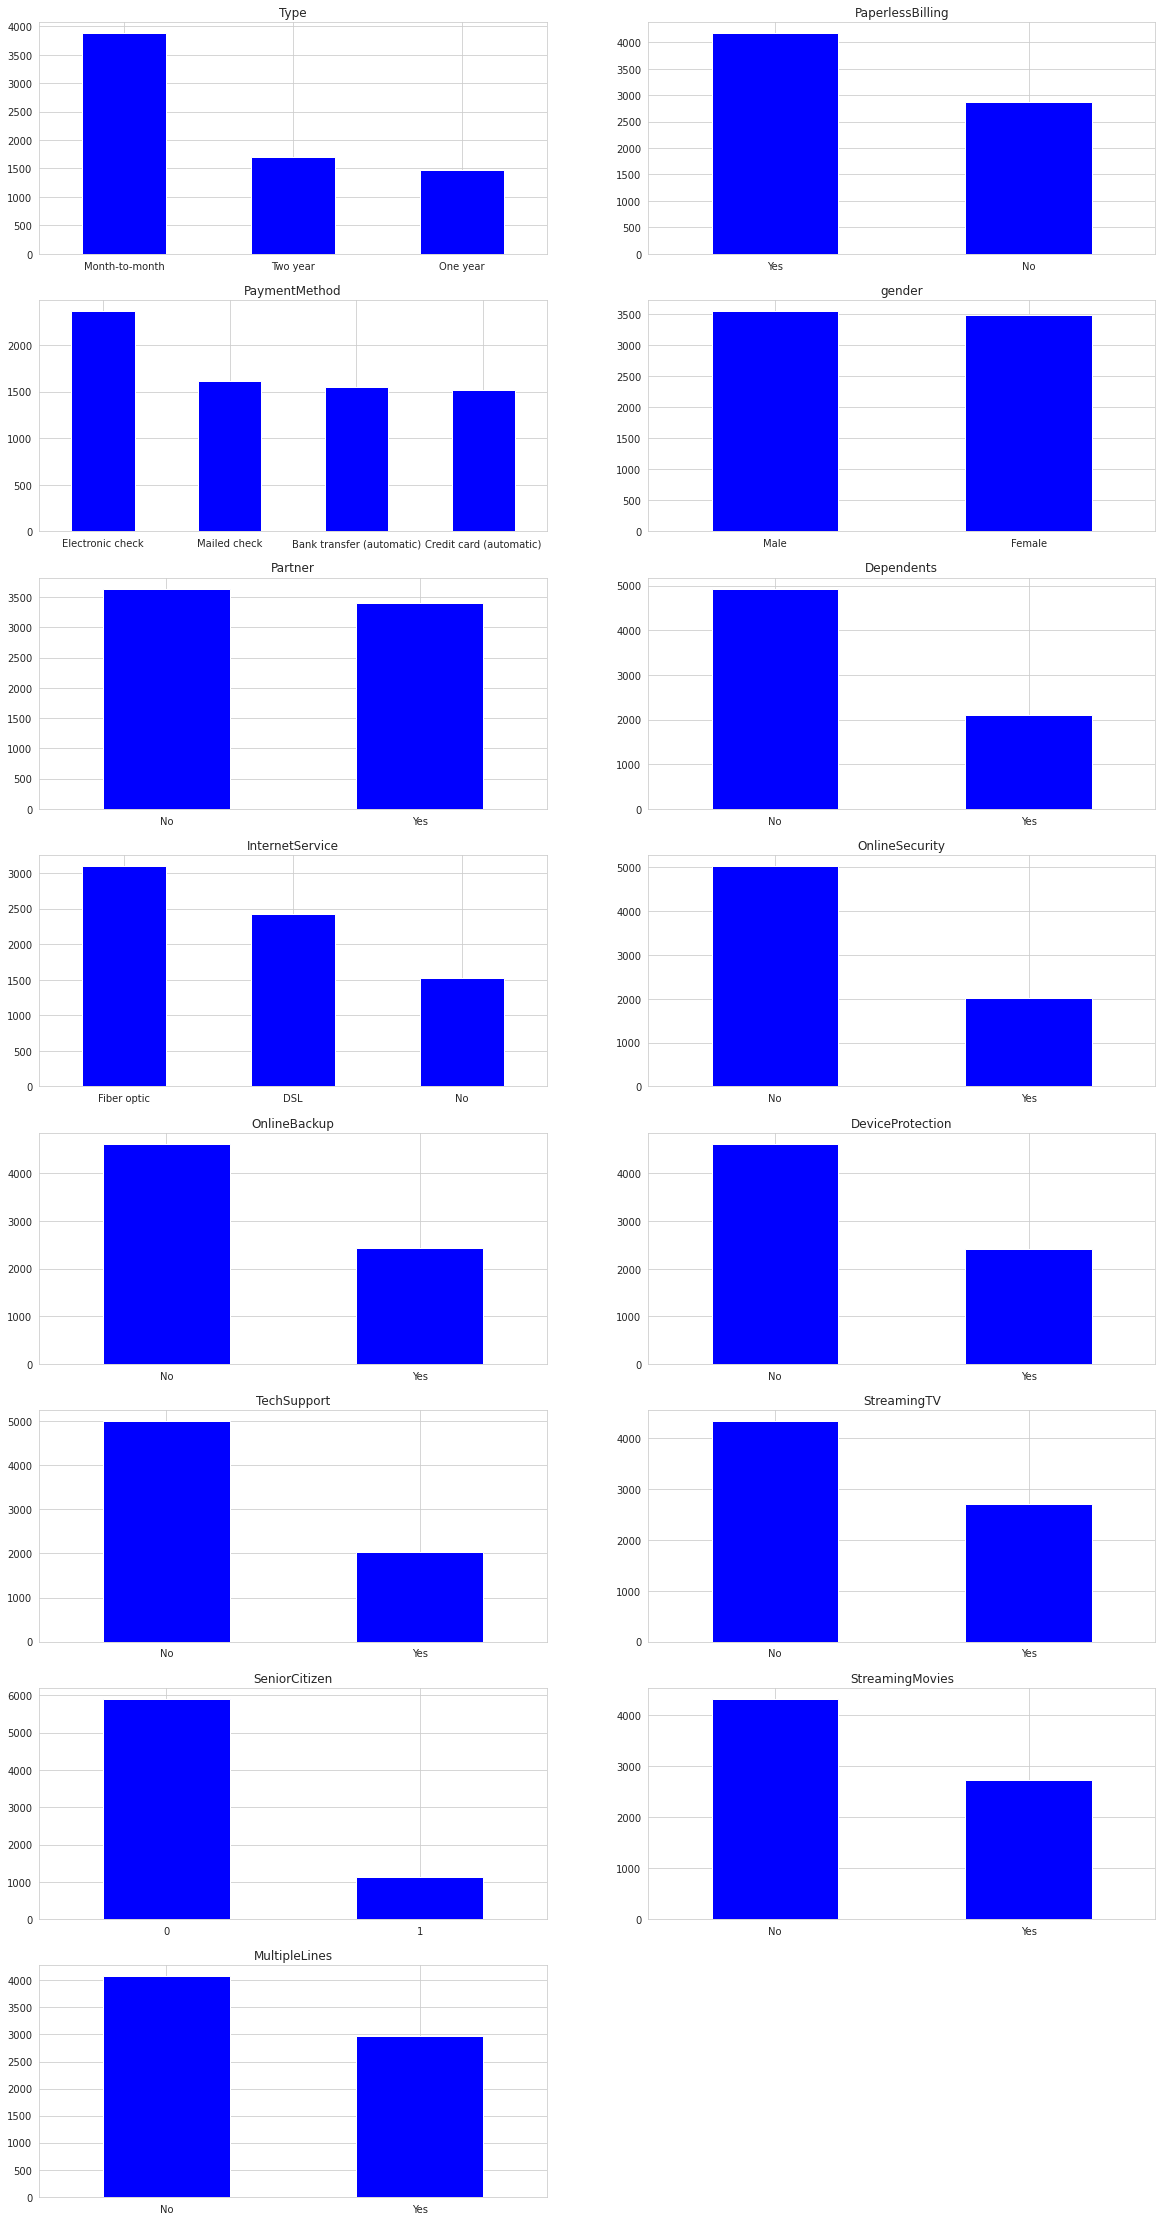

In [23]:
# Построим гистограммы с по категориальным признакам 
cols = 2
rows = int(np.ceil(len(cat_columns) / cols))

plt.figure(figsize=(20, 40))

for idx, column in enumerate(cat_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    client_df[column].value_counts().plot(
        kind='bar',
        color = 'blue',
        title=column,
        rot=0 # установим вертикальное расположение росписей
    )
        
plt.show()

Исходя из графиков можно сделать следующие выводы:
* Клиенты чаще всего пользуются ежемесячным типом оплаты и безналичным расчетом
* Клиенты чаще всего предпочитают получать счета в элеткронном виде и оплачивать услуги с помощью электронного чека
* Большая часть клиентов не находятся на иждевении и не имеет партнеров.

* Большая часть клиентов не пользуются дополнительными услугами

In [24]:
# Выставим размер всех графиков
plt.rcParams["figure.figsize"] = (20, 12)

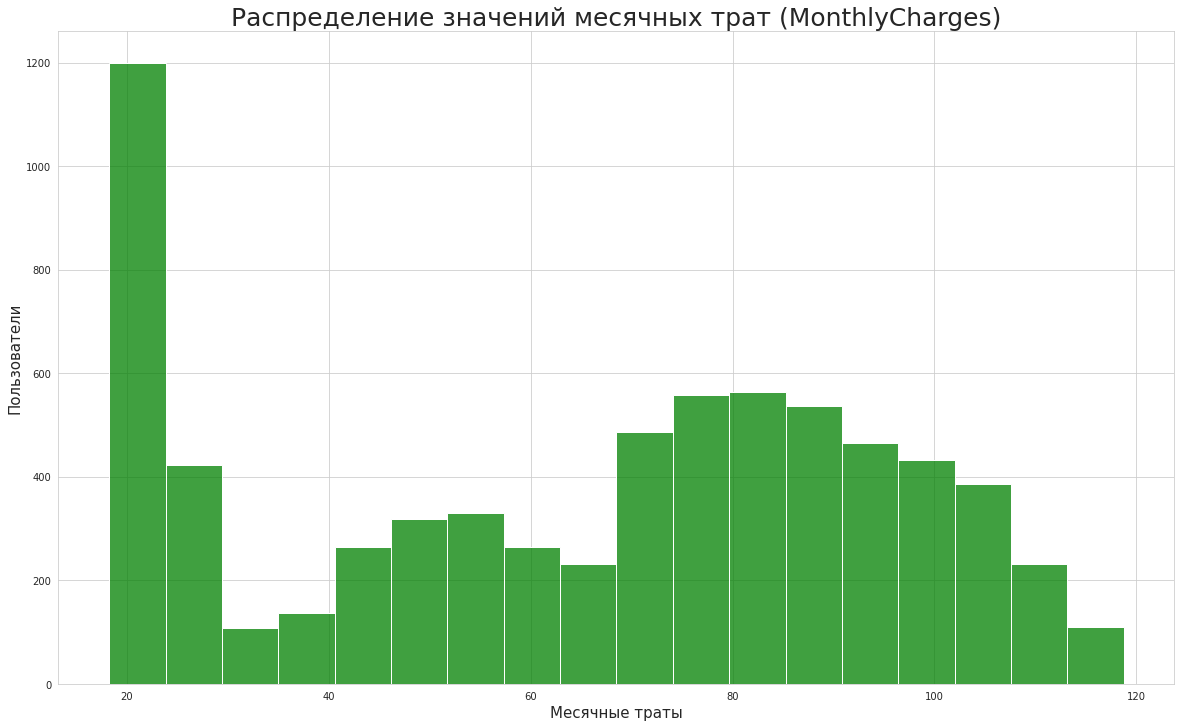

In [25]:
sns.histplot(client_df['MonthlyCharges'], color='Green')
plt.title('Распределение значений месячных трат (MonthlyCharges)', fontsize=25)
plt.xlabel('Месячные траты', fontsize=15)
plt.ylabel('Пользователи', fontsize=15);

На графике месячных трат выделяются три пика:
* Самый большой пик наблюдается с зарплатой от 20 до 30
* от 40 до 60
* от 70 до 120

In [26]:
# Проверим распределение клиентов по ежемесячным расходам qcut
client_df['Group_MonthlyCharges'] = pd.qcut(client_df['MonthlyCharges'], 3, labels=[0, 1, 2])

# Переведем таблицу в целочисленное значение
client_df['Group_MonthlyCharges'] = client_df['Group_MonthlyCharges'].astype(int)

In [27]:
# Создадим группы и найдем среднее значения
group = pd.DataFrame()
group['one_group'] = client_df.query('Group_MonthlyCharges == 0').describe().T['mean'] 
group['two_group'] = client_df.query('Group_MonthlyCharges == 1').describe().T['mean']
group['three_group'] = client_df.query('Group_MonthlyCharges == 2').describe().T['mean']
group

,one_group,two_group,three_group
MonthlyCharges,27.988622,69.036333,97.326438
TotalCharges,714.903445,1954.229424,4171.051555
SeniorCitizen,0.070608,0.160768,0.255219
Network_use_days,814.152701,864.112154,1279.912654
Group_MonthlyCharges,0.000000,1.000000,2.000000


Самый большой отток наблюдается у клиентов третьей группы 34%, затем идет вторая 29% и первая с 16 %

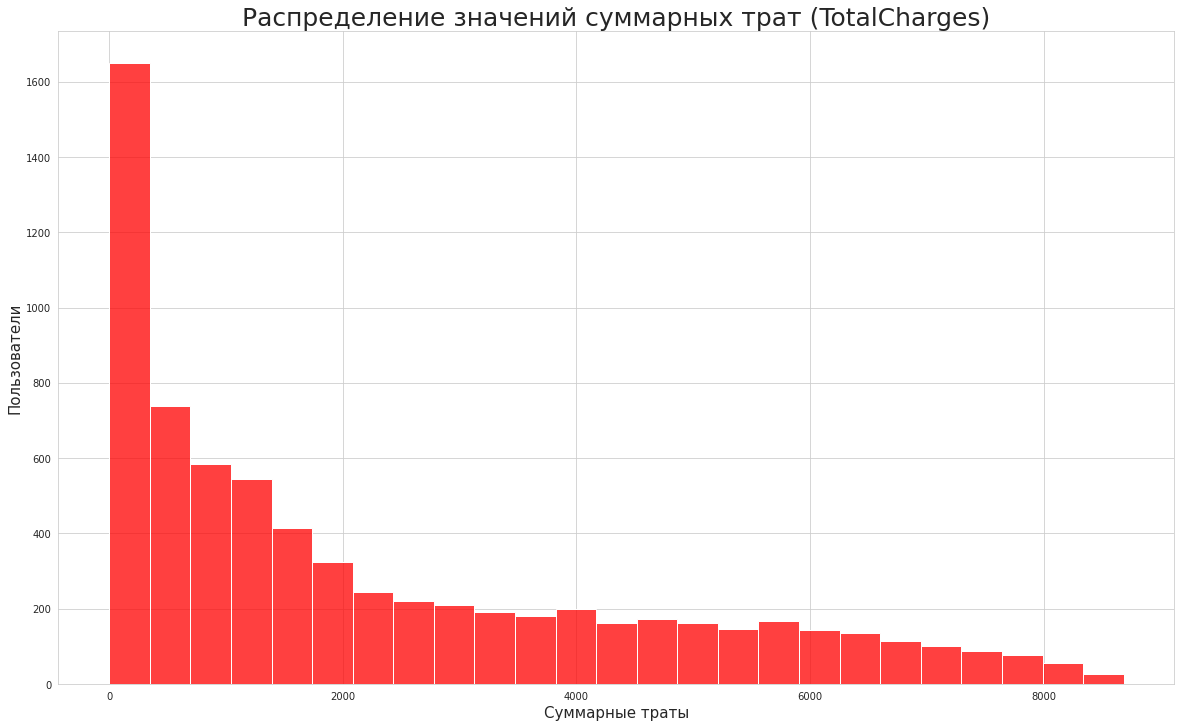

In [28]:
# Построим график суммарных трат
sns.histplot(client_df['TotalCharges'], color='Red')
plt.title('Распределение значений суммарных трат (TotalCharges)', fontsize=25)
plt.xlabel('Суммарные траты', fontsize=15)
plt.ylabel('Пользователи', fontsize=15);

График имеет логнормальное распределение, скорее всего это связанно с пропусками 

In [29]:
# Выведем значения TotalCharges равные нулю
client_df.query('TotalCharges == 0')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Network_use_days,Group_MonthlyCharges
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,1
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0,Male,0,No,...,No,No,No,No,No,No,No,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,1
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0,Male,0,Yes,...,No,No,No,No,No,No,No,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,1
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0,Male,0,Yes,...,No,No,No,No,No,No,No,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0,Male,0,Yes,...,No,No,No,No,No,No,No,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0,Female,0,Yes,...,No,No,No,No,No,No,No,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0,Male,0,Yes,...,No,No,No,No,No,No,No,No,0,0


Нулевые значения связаны с новыми клиентами, которые начали пользоваться услугами недавно

In [30]:
# Заполним пропущенные значения по таблице ежемесячных трат
client_df.loc[client_df['TotalCharges'] == 0, 'TotalCharges'] = client_df['MonthlyCharges']
client_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Network_use_days,Group_MonthlyCharges
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.0,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.0,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,1036,1
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.0,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,61,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.0,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.0,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,61,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.0,Male,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,730,2
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.0,Female,0,Yes,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2191,2
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.0,Female,0,Yes,...,DSL,Yes,No,No,No,No,No,No,337,0


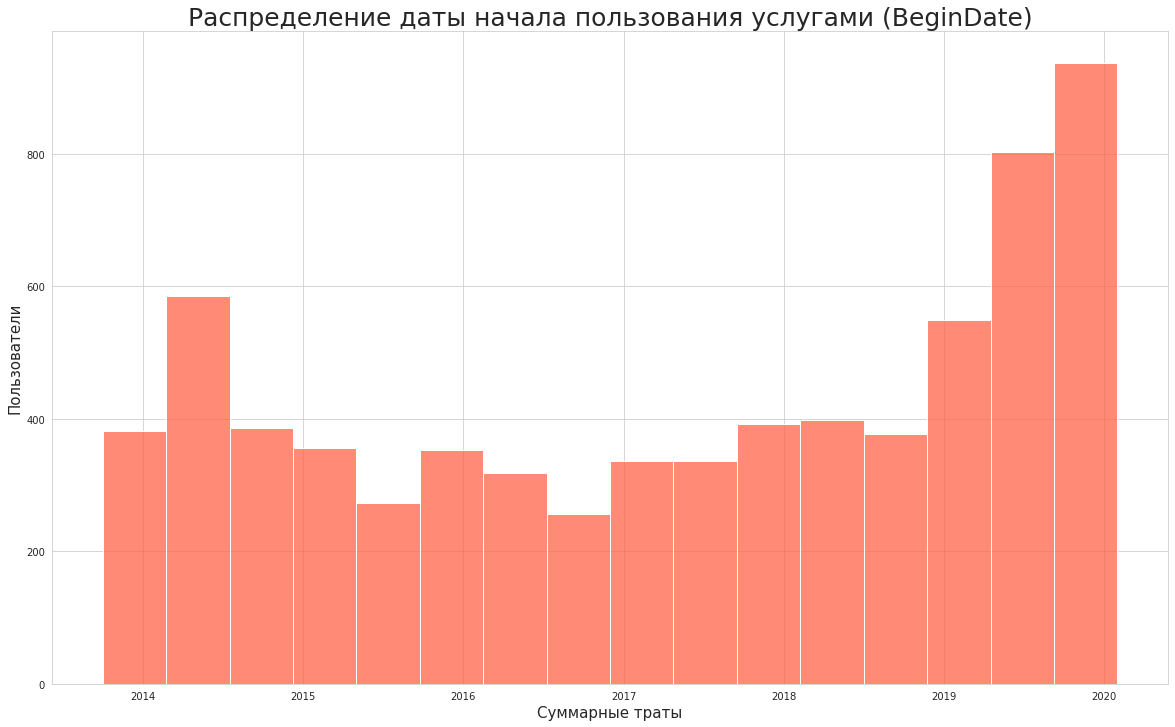

In [31]:
# Построим график регистрации клиентов
sns.histplot(client_df['BeginDate'], color='Tomato')
plt.title('Распределение даты начала пользования услугами (BeginDate)', fontsize=25)
plt.xlabel('Суммарные траты', fontsize=15)
plt.ylabel('Пользователи', fontsize=15);

C 2014 года наблюдался подъем регистраций клиентов, как вариант, связанная с началом работы компании. Начиная с 2015 по 2018 наблюдались незначительные колебания регистраций клиентов. С 2019 по 2020 начался снова прирост клиентов, возможно связанно с рекламой, которую могла запустить компания.   

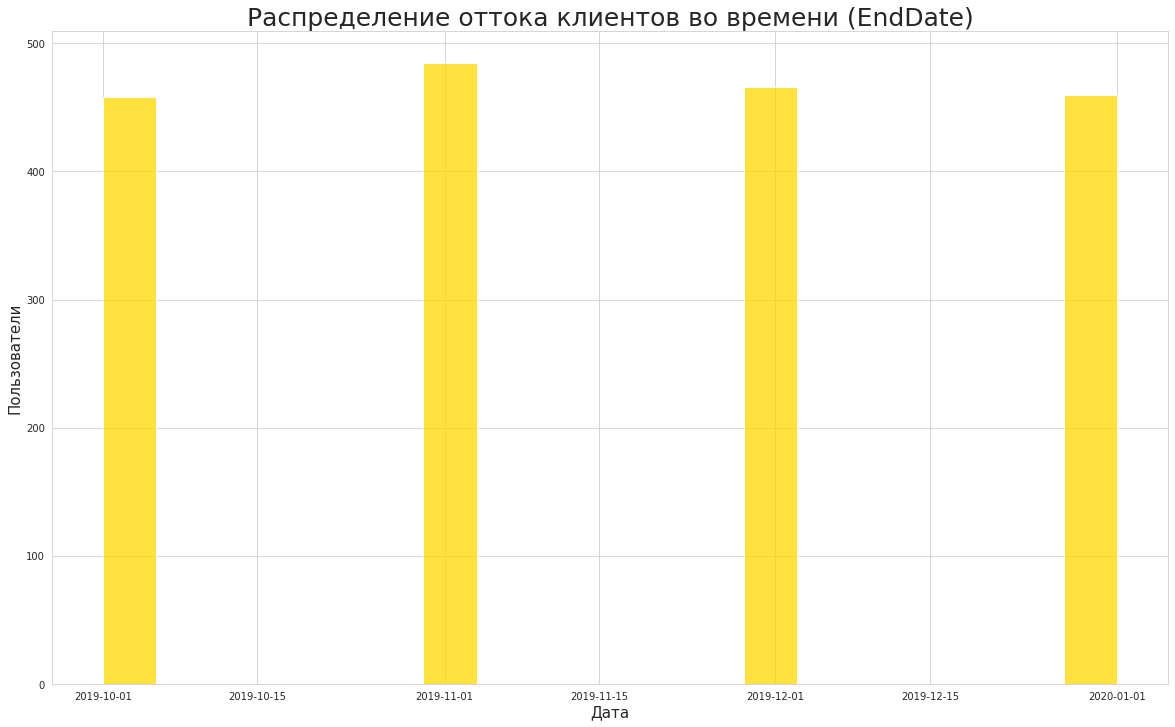

In [32]:
# Рассмотрим распределение оттока клиентов по последнему году
sns.histplot(client_df.query('EndDate != "2020-02-01"')['EndDate'], color='Gold')
plt.title('Распределение оттока клиентов во времени (EndDate)', fontsize=25)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Пользователи', fontsize=15);

В целом наблюдаются незначительные изменения оттока клиентов.

In [ ]:
# Создадим целевой признак ушедших клиентов 
client_df['Lost_clients'] = (client_df['EndDate'] != "2020-02-01") * 1

# Проверим данные на дисбаланс классов
client_df['Lost_clients'].value_counts(normalize=True)

Наблюдается явный дисбаланс классов целевого признака

In [ ]:
# Построим график общих клиентов и клиентов, которые расторгли контракт
ax = sns.histplot(client_df.query('Lost_clients== 1')['MonthlyCharges'], 
                  color='red', 
                  label='Клиенты, расторгнувшие контракт')
sns.histplot(client_df['MonthlyCharges'],
             color='blue',
             ax=ax, 
             alpha=0.3, 
             label='Клиенты, пользующиеся услугами')
ax.legend(fontsize=15)
plt.title('Распределение значений ежемесячных трат (MonthlyCharges)', fontsize=25)
plt.xlabel('Ежемесячные траты', fontsize=15)
plt.ylabel('Пользователи', fontsize=15);

Клиенты имеющие большой тариф, уходят чаще, чем клиенты с меньшим тарифом. Проверим, как часто ушедшие клиенты пользовались услугами компании.

In [ ]:
# Построим график
ax = sns.histplot(client_df.query('Lost_clients== 1')['Network_use_days'],
                  color='Purple', 
                  label='Клиенты, расторгнувшие контракт')
sns.histplot(client_df['Network_use_days'],
             color='Navy',
             ax=ax, 
             alpha=0.3, 
             label='Клиенты, пользующиеся услугами')
ax.legend(fontsize=15)
plt.title('Распределение значений длительности использования услуг (TotalTime)', fontsize=25)
plt.xlabel('Длинтельность использования услуг, дней', fontsize=15)
plt.ylabel('Пользователи', fontsize=15);

Практически большая часть клиентов, имеющая большой тариф, не пользовались им.

**Вывод:** 
1. Произведена замена пустых значений на NO таблицы EndDate.
2. Таблицы BeginDate и EndDate приведены к формату datetime
3. Таблица TotalCharges приведена к формату int
4. Все фреймы объединены в один по индификатору клиента customerID
5. После объединения в таблицах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines появились пропущенные значения. Было принято решение заменить их на No, так это связано с тем  что некоторые клиенты не пользовались, какими-то услугами оператора
6. Создан столбец Network_use_days, который отрожает сколько пользователей пользовались сетью
7. Построены гистограммы по которым можно сказать следующее:
 * Клиенты чаще всего пользуются ежемесячным типом оплаты и безналичным расчетом
 * Клиенты чаще всего предпочитают получать счета в элеткронном виде и оплачивать услуги с помощью электронного чека
 * Большая часть клиентов не находятся на иждевении и не имеет партнеров
 * Большая часть клиентов не пользуются дополнительными услугами
8. Построенны графики по таблицам MonthlyCharges, TotalCharges, BeginDate, EndDate. По ним можно определены следущее:
 * На графике таблицы MonthlyCharges, выделяются три пика, в результате чего была создана таблица Group_MonthlyCharges, с помщью которй три пика были разбиты по группам. Исходя из анализа стоит отметить, что самый большой отток клиентов наблюдается в третьем пике 34%
 * График TotalCharges имеет логнормальное распределение, нулевые значения которых связаны с новыми клиентами, которые начали пользоваться услугами недавно
 * На графике BeginDate с 2014 года наблюдался подъем регистраций клиентов, как вариант, связанная с началом работы компании. Начиная с 2015 по 2018 наблюдались незначительные колебания регистраций клиентов. С 2019 по 2020 начался снова прирост клиентов, возможно связанно с рекламой, которую могла запустить компания
 * На графике EndDate наблюдается незначительное изменение оттока клиентов
9. Выделен целевой признак Lost_clients, у которого наблюдается дисбаланс классов (74/26). На этапе подготовки данных для модели нужно решить эту проблему методом семплирования. Также можно использовать метрику устойчивую к дисбалансу классов (например AUC-ROC, F1)
10. Построены графики распределения значений ежемесячных трат (MonthlyCharges) и распределение значений длительности использования услуг (TotalTime) клиентов, которое пользуются услугами и которые расторгли контракт. Так стоит отметить, что:
 * Клиенты имеющие большой тариф, уходят чаще, чем клиенты с меньшим тарифом
 * Практически большая часть клиентов, имеющая большой тариф, не пользуется им

# Подготовка данных для обучения модели

In [ ]:
# Зафиксируем Random_State
RS = 80523

In [ ]:
# Удалим столбцы с датами
client_df = client_df.drop(['BeginDate', 'EndDate'], axis=1)
client_df.columns

In [ ]:
# Разделим датафрейм на основную и целевую выборку
target = client_df['Lost_clients']
features = client_df.drop('Lost_clients', axis=1)


print('Размер признаков:', target.shape)
print('Размер целевого признака:', features.shape)

In [ ]:
# Разделим данные на тренировачную и тестевую выборки
train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=RS)

# Проверим размер выборок 
print('Размер тренировочной выборки признаков:', train_features.shape, 
          'целевого признака:', train_target.shape, sep='\n')
print('Размер тестовой выборки признаков:', test_features.shape, 
          'целевого признака:', test_target.shape, sep='\n')

In [ ]:
# Закадируем тренеровачную выборку
encoder = OrdinalEncoder()

# Обучим encoder на тренеровачной выборке
encoder.fit(train_features[cat_columns])

# Закадируем тренеровачную выборку
train_features[cat_columns] = encoder.transform(train_features[cat_columns])
train_features.info()

In [ ]:
# Закадируем тестовую выборку
test_features[cat_columns] = encoder.transform(test_features[cat_columns])
test_features

Фрейм разделен на основные признаки и целевой признак, а также на тренировачную часть и тестевую (75:25). Произведем балансировку и масштаб признаков

In [ ]:
# Создадим функцию upsample, которое увеличит число объектов меньшего класса путем многократного копирования
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RS)
    
    return features_upsampled, target_upsampled

In [ ]:
# Провидем балансировку классов 
#train_features, train_target = upsample(train_features, train_target, 3)

# Обучение модели 

## Модель LogisticRegression

In [ ]:
%%time
lr_params = {'model_lr__C': [1, 2, 3, 5], 
             'model_lr__class_weight': [None, 'balanced'],
             'model_lr__fit_intercept': [True, False],
             'model_lr__l1_ratio': [None],
             'model_lr__random_state':[RS]} 

model_lr =  LogisticRegression(random_state=RS)
scaler = StandardScaler()

pipe = Pipeline(steps=[('scaler', scaler), ('model_lr', model_lr)])

gs_lr = RandomizedSearchCV(estimator=pipe, param_distributions = lr_params, n_jobs=-1,
                      cv=5, scoring='roc_auc', random_state=RS)

gs_lr.fit(train_features, train_target)

f1_lr = np.mean(cross_val_score(gs_lr,
                           train_features, 
                           train_target, cv=5, 
                           scoring=make_scorer(f1_score)))

roc_auc_lr = np.mean(cross_val_score(gs_lr, 
                           train_features, 
                           train_target, cv=5, 
                           scoring=make_scorer(roc_auc_score)))

print('Оптимальные параметры модели:', gs_lr.best_params_)
print('Значение F1 на тренировачной выбоке:', f1_lr) 
print('Значение ROC_AUC на тренировачной выборке:', roc_auc_lr)

## Модель RandomForestClassifier

In [ ]:
%%time
rfc_params = {'model_rfc__n_estimators': [200, 150, 300, 400],
               'model_rfc__max_depth': [2, 5, 2],
               'model_rfc__class_weight':['balanced'],
               'model_rfc__random_state':[RS]} 

model_rfc = RandomForestClassifier(random_state=RS)
scaler = StandardScaler()

pipe = Pipeline(steps=[('scaler', scaler), ('model_rfc', model_rfc)])

gs_rfc = RandomizedSearchCV(estimator=pipe, param_distributions = rfc_params, n_jobs=-1,
                      cv=5, scoring='roc_auc', random_state=RS)

gs_rfc.fit(train_features, train_target)

f1_rfc = np.mean(cross_val_score(gs_rfc,
                           train_features, 
                           train_target, cv=5, 
                           scoring=make_scorer(f1_score)))

roc_auc_rfc = np.mean(cross_val_score(gs_rfc, 
                           train_features, 
                           train_target, cv=5, 
                           scoring=make_scorer(roc_auc_score)))

print('Оптимальные параметры модели:', gs_rfc.best_params_)
print('Значение F1 на тренировачной выбоке:', f1_rfc) 
print('Значение ROC_AUC на тренировачной выборке:', roc_auc_rfc)

## Модель CatBoostClassifier

In [ ]:
%%time
cb_params = {'model_cb__eval_metric': ['AUC'], 
             'model_cb__learning_rate': [.1, .01, .5],
             'model_cb__iterations': [500],
             'model_cb__random_state':[RS]} 

model_cb =  CatBoostClassifier(random_state=RS)
scaler = StandardScaler()

pipe = Pipeline(steps=[('scaler', scaler), ('model_cb', model_cb)])

gs_cb = RandomizedSearchCV(estimator=pipe, param_distributions = cb_params, n_jobs=-1,
                      cv=5, scoring='roc_auc', random_state=RS)

gs_cb.fit(train_features, train_target)

#best_params_cb = gs_cb.best_params_

f1_cb = np.mean(cross_val_score(gs_cb,
                           train_features, 
                           train_target, cv=5, 
                           scoring=make_scorer(f1_score)))

roc_auc_cb = np.mean(cross_val_score(gs_cb, 
                           train_features, 
                           train_target, cv=5, 
                           scoring=make_scorer(roc_auc_score)))

print('Оптимальные параметры модели:', gs_cb.best_params_)
print('Значение F1 на тренировачной выбоке:', f1_cb) 
print('Значение ROC_AUC на тренировачной выборке:', roc_auc_cb)

Лучшее значение на тренировачной выборке показала модель CatBoostClassifier

# Тестирование модели 

In [ ]:
# Создадим функцию для тестирования модели
def testing_model(f_test, t_test, model):
    predictions_test = model.predict(f_test)
    probabilities_test = model.predict_proba(f_test)[:,1]
    fpr, tpr, threshold = roc_curve(t_test, probabilities_test)
    
    f1 = f1_score(t_test, predictions_test)
    roc_auc = roc_auc_score(t_test, probabilities_test)
    
    print('Класс модели: ', type(model).__name__)
    print('F1-мера на тестевой выборке: ', f1)
    print('ROC-AUC на тестевой выборке: ', roc_auc)
    
    # Построим график кривой ROC-AUC
    fpr, tpr, thresholds = roc_curve(t_test, probabilities_test, pos_label=1)
    plt.plot(fpr, tpr, label=type(model).__name__, color='red')
    plt.xlabel('Вероятность ошибки 1-рода', fontsize=15)
    plt.ylabel('Recall', fontsize=15)
    plt.title('ROC-кривая модели класса ' + type(model).__name__, fontsize=25)
    plt.plot([0, 1], [0, 1], color='black')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend();
    
    # Создадим матрицу ошибок 
    cmatrix = confusion_matrix(t_test, predictions_test)
    plt.figure(figsize=(8, 8))

    sns.heatmap(cmatrix, 
                annot=True,  
                cmap='magma_r', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
    plt.show();

In [ ]:
# Протестируем лучшую модель через функцию
testing_model(test_features, test_target, gs_cb)

**Вывод:** Модель CatBoostClassifier, показала лучшее значение: 
 * ROC-AUC: 0,92
 * F1-мера: 0,71
 
Модель показывает хорошую долю позитивных (TP=315) и ложнонегативных (FN=163) предсказаний и склоняется в большую сторону к позитивным предсказаниям

# Анализ важности признаков модели

In [ ]:
# Cоздадим пайплайн
pipe = Pipeline([('cbc', CatBoostClassifier(random_state=42, **gs_cb.best_params_))])

# Обучаем модель на данных
pipe.fit(train_features, train_target)

# Получаем модель из пайплайна
model_cbc = pipe.named_steps['cbc']

# Получаем важности признаков
importances = model_cbc.feature_importances_ 


In [ ]:
# Переводим важности признаков в датафрейм
importances_df = pd.DataFrame(importances, index=test_features.columns, columns=['importance'])

# Сортируем важности признаков от большего к меньшему
importances_df = importances_df.sort_values(by='importance',  ascending=False)

# Отображаем важности признаков в виде графика
importances_df.plot(kind='bar', color='indigo', title='Важность факторов')
plt.show()

**Вывод:** Самыми важными признаками, влияющими на то, что клиент останется является время использования услуг. Следующими важными факторами будут тип оплаты и ежемесячные траты на услуги.

# Вывод

Целью данной работы являлось создание модели, которая на основании имеющихся даннных будет предсказывать уход клиента от компании. Целевой метрикой оценки точности предсказания модели считатется AUC-ROC, которая должна быть больше или равна 0,85 на тестевой выборке.

При выполнении работы были загружены и рассмотрены следующие фреймы с данными:

df_contract (информация о договоре);
df_internet (информация об интернет-услугах);
df_personal (персональные данные клиента);
df_phone (информация об услугах телефонии). 

Эти данные включают в себя информацию о датах заключения контракта, дате разрыва контракта, суммы затрат на ежемесячные платежи и общие суммы затрат клиентов, персональной информации о клиентах, сведения об услугах интрернета, телефонии и доп. услугах. Все данные изученны и по ним сделанны предварительные выводы

На предобработке данных было сделанно следующее:
  1. Таблица BeginDate приведена к формату datetime
  2. Значения No в таблице EndDate заменены на дату (2020-02-01)
  3. Таблица MonthlyCharges приведена к целочисленному типу для экономии памяти
  
все четыре фрейма с иходными значениями были объединены в один датасет.
После приведения столбца TotalCharges к числовому формату было обнаружено 11 пропусков  для пользователей, которые оформили договор на момет выгрузки данных. Так как не все клиенты пользовались услугами интернета/телефона, то после объединения появились пропущенные значения в количестве **1526** шт. для столбцов из фрейма internet_df и **682** пропуска из фрейма phone_df.
Все они были обработаны на подходящие значения.

Из анализа данных можно выделить следующее:
 * Практически большая часть пользователей предпочитают безналичный расчет
 * По распределению значений наблюдаются три пика:
   1. Клиенты с месячными тратами со значениями 20-30
   2. Клиенты с месячными тратами со значениями 30-70
   3. Клиенты с месячными тратами со значениями 70-120
 * Иследование графиков по распределению даты регистрации клиентов показало, что пик наблюдался в начале 2014 года, что связано с началом работы компании, затем наблюдался период стогнации с 2015 по 2018 год и после 2018 начался бурный рост новых клиентов.
 * Основные клиенты расторгнувшие контрак пользовались дорогими тарифами.
 * Средняя длитильность пользования услугами у ушедших клиентов практически в два раза меньше, чем клиентов, которые остались.

Из датасета был выделен целевой признак - **Lost_clients**, который имеет дисбаланс классов (74:26). Так же, был добавлен столбец Network_use_days с количеством дней от регистрации договора до текущей даты/даты выгрузки.

Из обучения модели можно выделить следующее:
1. Для решения задачи классификации и предсказания факта ухода были обчены три модели:
   * LogisticRegression
   * RandomForestClassifier
   * CatBoostClassifier

2. Выборка была поделена в соотношении (тренировачная: 75%, тестовая:25%)
3. Подбор гиперпараметров осуществлялся с помощью  RandomizedSearchCV с кросс-валидацией. Также была выполнена стандартизация с помощью пайплайна. 
4. Лучшей моделью на тренировачной выборке (AUC-ROC:*0*) оказалась CatBoostClassifier c набором параметров:({'iterations': 500, 'learning_rate': 0.5, 'depth': 3, 'l2_leaf_reg': 5, 'loss_function': 'CrossEntropy', 'eval_metric': 'AUC', 'random_state': RS[80523})
5. На тестевой выборке модель  CatBoostClassifier показала значение AUC-ROC:0,92. Модель показывает хорошую долю позитивных (TP=315) и ложнонегативных (FN=163) предсказаний и склоняется в большую сторону к позитивным предсказаниям 
6. Самыми важными признаками, влияющими на то, что клиент останется является время использования услуг. Следующими важными факторами будут тип оплаты и ежемесячные траты на услуги.